<a href="https://colab.research.google.com/github/Tuttusa/TVAE/blob/main/Leoleo_Iteration1_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pathlib
from google.colab import drive
def create_file_folder(project_name):
  gdrive_path = pathlib.Path("/content/gdrive", force_remount=True)
  project_path = gdrive_path.joinpath(f"My Drive/Université/PhD/Recherche/Collabfiles/{project_name}")
  drive.mount(gdrive_path.as_posix())
  project_path.mkdir(parents=True, exist_ok=True)
  return project_path

project_path = create_file_folder("Leoleo_Iteration1_VAE")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**VAE**

The *vae* allows for the embedding of the data into a latent space

In [ ]:
# missing installs
# !pip install optuna
# !pip install torchmetrics
#!pip install git+https://github.com/Tuttusa/EvidentialDL.git

In [15]:
import numpy as np
import pickle
import matplotlib

from fastai.callback.core import Callback
from fastai.callback.fp16 import MixedPrecision
from fastai.callback.schedule import combine_scheds, SchedCos, SchedNo, ParamScheduler
from fastai.callback.training import GradientClip
from fastai.data.block import TransformBlock, CategoryBlock, RegressionBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import Normalize, RandomSplitter
from fastai.imports import noops
from fastai.layers import Swish, LinBnDrop, SigmoidRange
from fastai.learner import Metric
from fastai.losses import CrossEntropyLossFlat, MSELossFlat
from fastai.optimizer import ranger
from fastai.tabular.core import TabularPandas, TabDataLoader, Categorify, FillMissing, TabularProc
from fastai.tabular.learner import TabularLearner, tabular_learner
from fastai.tabular.model import get_emb_sz, TabularModel
from fastai.torch_core import tensor, to_device, Module, to_detach, flatten_check
from fastcore.basics import store_attr, range_of
from fastcore.foundation import L
from fastcore.meta import delegates
from fastcore.transform import ItemTransform
import torch
import pandas as pd
import optuna
from scipy.stats import entropy
from torch import nn, HalfTensor
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from torch.distributions import Normal
from torchmetrics import MeanAbsolutePercentageError
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from evidentialdl.layers import DenseNormalGamma, DenseDirichlet
from evidentialdl.losses import evidential_regression_loss, dirichlet_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Training the VAE

In [16]:
class ReadTabBatchIdentity(ItemTransform):
    "Read a batch of data and return the inputs as both `x` and `y`"

    def __init__(self, to):
        super().__init__()
        store_attr()

    def encodes(self, to):
        if not to.with_cont:
            res = (tensor(to.cats).long(),) + (tensor(to.cats).long(),)
        else:
            res = (tensor(to.cats).long(), tensor(to.conts).float()) + (
                tensor(to.cats).long(), tensor(to.conts).float())
        if to.device is not None:
            res = to_device(res, to.device)
        return res


class TabularPandasIdentity(TabularPandas):

    @property
    def total_cats(self):
        return {k: len(v) for k, v in self.classes.items()}

    @property
    def low(self):
        return (self.cont_min - np.array(list(self.means.values()))) / np.array(list(self.stds.values()))

    @property
    def high(self):
        return (self.cont_max - np.array(list(self.means.values()))) / np.array(list(self.stds.values()))


@delegates()
class TabDataLoaderIdentity(TabDataLoader):
    "A transformed `DataLoader` for AutoEncoder problems with Tabular data"
    do_item = noops

    def __init__(self, dataset, bs=16, shuffle=False, after_batch=None, num_workers=0, **kwargs):
        if after_batch is None:
            after_batch = L(TransformBlock().batch_tfms) + ReadTabBatchIdentity(dataset)
        super().__init__(dataset, bs=bs, shuffle=shuffle, after_batch=after_batch, num_workers=num_workers, **kwargs)

    def create_batch(self, b): return self.dataset.iloc[b]

    def do_item(self, s): return 0 if s is None else s


TabularPandasIdentity._dl_type = TabDataLoaderIdentity


class SetMinMax(TabularProc):

    def encodes(self, to):
        to.cont_min = to[to.cont_names].min().values
        to.cont_max = to[to.cont_names].max().values


class BatchSwapNoise(Module):
    "Swap Noise Module"

    def __init__(self, p):
        super().__init__()
        store_attr()

    def forward(self, x):
        if self.training:
            mask = torch.rand(x.size()) > (1 - self.p)
            l1 = torch.floor(torch.rand(x.size()) * x.size(0)).type(torch.LongTensor)
            l2 = (mask.type(torch.LongTensor) * x.size(1))
            res = (l1 * l2).view(-1)
            idx = torch.arange(x.nelement()) + res
            idx[idx >= x.nelement()] = idx[idx >= x.nelement()] - x.nelement()
            return x.flatten()[idx].view(x.size())
        else:
            return x


class TabularVAE(TabularModel):
    def __init__(self, emb_szs, n_cont, hidden_size, cats, low, high, layers=[1024, 512, 256], ps=0.2,
                 embed_p=0.01, bswap=None, act_cls=Swish()):
        super().__init__(emb_szs, n_cont, layers=layers, out_sz=hidden_size, embed_p=embed_p, act_cls=act_cls)

        self.bswap = bswap
        self.cats = cats
        self.activation_cats = sum([v for k, v in cats.items()])

        self.layers = nn.Sequential(
            *L(self.layers.children())[:-1] + nn.Sequential(LinBnDrop(256, hidden_size, p=ps, act=act_cls)))

        self.fc_mu = nn.Linear(hidden_size, hidden_size)
        self.fc_std = nn.Linear(hidden_size, hidden_size)

        if self.bswap != None: self.noise = BatchSwapNoise(self.bswap)
        self.decoder = nn.Sequential(
            LinBnDrop(hidden_size, 256, p=ps, act=act_cls),
            LinBnDrop(256, 512, p=ps, act=act_cls),
            LinBnDrop(512, 1024, p=ps, act=act_cls)
        )

        self.decoder_cont = nn.Sequential(
            LinBnDrop(1024, n_cont, p=ps, bn=False, act=None),
            SigmoidRange(low=low, high=high)
        )

        self.decoder_cat = LinBnDrop(1024, self.activation_cats, p=ps, bn=False, act=None)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = HalfTensor(*mu.size()).normal_().to(self.device)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc_mu(h), F.softplus(self.fc_std(h))
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x_cat, x_cont=None):
        encoded = super().forward(x_cat, x_cont)
        z, mu, logvar = self.bottleneck(encoded)

        return z, mu, logvar

    def decode(self, z):
        decoded_trunk = self.decoder(z)

        decoded_cats = self.decoder_cat(decoded_trunk)

        decoded_conts = self.decoder_cont(decoded_trunk)

        return decoded_cats, decoded_conts

    def forward(self, x_cat, x_cont=None, encode=False):
        if (self.bswap != None):
            x_cat = self.noise(x_cat)
            x_cont = self.noise(x_cont)

        z, mu, logvar = self.encode(x_cat, x_cont)
        if (encode): return z

        decoded_cats, decoded_conts = self.decode(z)

        return decoded_cats, decoded_conts, mu, logvar



In [17]:
class VAERecreatedLoss(Module):
    "Measures how well we have created the original tabular inputs, plus the KL Divergence with the unit normal distribution"

    def __init__(self, cat_dict, dataset_size, bs, total_cats):
        super().__init__()
        ce = CrossEntropyLossFlat(reduction='sum')
        mse = MSELossFlat(reduction='sum')
        store_attr('cat_dict,ce,mse,dataset_size,bs,total_cats')

    def forward(self, preds, cat_targs, cont_targs):
        if (len(preds) == 5):
            cats, conts, mu, logvar, kl_weight = preds
        else:
            cats, conts, mu, logvar = preds
            kl_weight = 1

        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        CE = cats.new([0])
        pos = 0
        for i, (k, v) in enumerate(self.total_cats.items()):
            CE += self.ce(cats[:, pos:pos + v], cat_targs[:, i])
            pos += v

        norm_cats = cats.new([len(self.total_cats.keys())])
        norm_conts = conts.new([conts.size(1)])
        total = (self.mse(conts, cont_targs) / norm_conts) + (CE / norm_cats)

        # This factor depends on your batch size and the size of the dataset.  A good rule of thumb is df.shape[0] / batch_size
        # if we don't have this, the KLD loss might become much larger than the reconstruction loss
        total *= self.dataset_size / self.bs

        return (total + (kl_weight * KLD)) / cats.size(0)


class AnnealedLossCallback(Callback):
    def after_pred(self):
        kl = self.learn.pred[0].new(1)
        opt = self.opt.hypers[0]
        if 'kl_weight' in opt:
            kl[0] = self.opt.hypers[0]['kl_weight']
            self.learn.pred = self.learn.pred + (kl,)

    def after_batch(self):
        if (len(self.learn.pred) > 4):
            cats, conts, mu, logvar, _ = self.learn.pred
        else:
            cats, conts, mu, logvar = self.learn.pred

        self.learn.pred = (cats, conts, mu, logvar)



In [27]:

class MSEMetric(Metric):
    def __init__(self): self.preds = []

    def accumulate(self, learn):
        cats, conts, mu, logvar = learn.pred
        cat_targs, cont_targs = learn.y
        norm_conts = conts.new([conts.size(1)])
        self.preds.append(to_detach(F.mse_loss(conts, cont_targs, reduction='sum') / norm_conts))

    @property
    def value(self):
        return torch.Tensor(self.preds).mean()


class CEMetric(Metric):
    def __init__(self, total_cats):
        self.preds = []
        self.total_cats = total_cats

    def accumulate(self, learn):
        cats, conts, mu, logvar = learn.pred
        cat_targs, cont_targs = learn.y
        CE = cats.new([0])
        pos = 0
        for i, (k, v) in enumerate(self.total_cats.items()):
            CE += F.cross_entropy(cats[:, pos:pos + v], cat_targs[:, i], reduction='sum')
            pos += v

        norm = cats.new([len(self.total_cats.keys())])
        self.preds.append(to_detach(CE / norm))

    @property
    def value(self):
        return torch.Tensor(self.preds).mean()


class KLDMetric(Metric):
    def __init__(self): self.preds = []

    def accumulate(self, learn):
        cats, conts, mu, logvar = learn.pred
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        self.preds.append(to_detach(KLD))

    @property
    def value(self):
        return torch.Tensor(self.preds).mean()


class MUMetric(Metric):
    def __init__(self): self.preds = []

    def accumulate(self, learn):
        cats, conts, mu, logvar = learn.pred
        self.preds.append(to_detach(mu.mean()))

    @property
    def value(self):
        return torch.Tensor(self.preds).mean()


class StdMetric(Metric):
    def __init__(self): self.preds = []

    def accumulate(self, learn):
        cats, conts, mu, logvar = learn.pred
        self.preds.append(to_detach((logvar.exp_() ** .5).mean()))

    @property
    def value(self):
        return torch.Tensor(self.preds).mean()


In [71]:
from sklearn.metrics import r2_score, mean_absolute_error


def mean_absolute_relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))


def continuous_performance(cont_preds, cont_targs, to, vae_uncert=None):
    """
    evaluate the performance on continuous columns
    """
    cont_preds = pd.DataFrame(cont_preds, columns=to.cont_names)
    cont_targs = pd.DataFrame(cont_targs, columns=to.cont_names)

    # preds = pd.DataFrame((cont_preds.values * stds.values) + means.values, columns=cont_preds.columns)
    preds = to_continuous_dataframe(cont_preds, to)
    targets = to_continuous_dataframe(cont_targs, to)

    mi = (np.abs(targets - preds)).min().to_frame().T
    ma = (np.abs(targets - preds)).max().to_frame().T
    mean = (np.abs(targets - preds)).mean().to_frame().T
    median = (np.abs(targets - preds)).median().to_frame().T
    r2 = pd.DataFrame.from_dict({c: [r2_score(targets[c], preds[c])] for c in preds.columns})
    mape = pd.DataFrame.from_dict({c: [mean_absolute_relative_error(targets[c], preds[c])] for c in preds.columns})

    r2.mean(axis=1)

    for d, name in zip([mi, ma, mean, median, r2, mape], ['Min', 'Max', 'Mean', 'Median', 'R2', 'MARE']):
        d = d.insert(0, 'GroupBy', name)

    data = pd.concat([mi, ma, mean, median, r2, mape])

    return data


def categorical_performance(cat_targs, cat_preds, to, vae_uncert=None):
    """
    evaluate the performance on categorical columns
    """
    cat_preds = to_cat_dataframe(cat_preds, to)

    cat_targs = pd.DataFrame(cat_targs, columns=to.cat_names)

    accuracy = pd.DataFrame.from_dict({c: [accuracy_score(cat_targs[c], cat_preds[c])] for c in cat_preds.columns})
    recall = pd.DataFrame.from_dict({c: [recall_score(cat_targs[c], cat_preds[c], average='weighted')]
                                     for c in cat_preds.columns})
    precision = pd.DataFrame.from_dict(
        {c: [precision_score(cat_targs[c], cat_preds[c], average='weighted')] for c in cat_preds.columns})

    f1 = pd.DataFrame.from_dict(
        {c: [f1_score(cat_targs[c], cat_preds[c], average='weighted')] for c in cat_preds.columns})

    for d, name in zip([accuracy, recall, precision, f1], ['Accuracy', 'Recall', 'Precision', 'F1']):
        d = d.insert(0, 'MetricName', name)

    gg = pd.concat([accuracy, recall, precision, f1])

    return gg


def to_continuous_dataframe(cont_preds, to):
    if isinstance(cont_preds, torch.Tensor):
        cont_preds = cont_preds.cpu().numpy()
    return pd.DataFrame((cont_preds * np.array(list(to.stds.values()))) + np.array(list(to.means.values())),
                        columns=to.cont_names)


def to_cat_dataframe(cat_preds, to):
    cat_reduced = np.zeros((cat_preds.shape[0], len(to.total_cats)))
    pos = 0
    for i, (k, v) in enumerate(to.total_cats.items()):
        cat_reduced[:, i] = cat_preds[:, pos:pos + v].argmax(axis=1)
        pos += v
    cat_reduced = pd.DataFrame(cat_reduced, columns=to.cat_names)
    return cat_reduced


def recon_df(cont_preds, cat_preds, to):
    cont_df = to_continuous_dataframe(cont_preds, to)
    cat_df = to_cat_dataframe(cat_preds, to)
    res = pd.concat([cat_df, cont_df], axis=1)
    return res


def transform(learn, df, to):
    "reconstruct a dataframe comming from the decoder to a real dataframe"
    dl = learn.dls.test_dl(df)
    x_cats = torch.cat(list(map(lambda x: x[0], dl)))
    x_conts = torch.cat(list(map(lambda x: x[1], dl)))

    x_conts = to_continuous_dataframe(x_conts, to)
    df_d = pd.concat([pd.DataFrame(x_cats, columns=to.cat_names), x_conts], axis=1)

    return df_d, x_cats, x_conts


def transform_df(x_vae_learn, x_to, t_vae_learn, t_to, df):
    "fully reconstruct a dataframe from a composition of two vaes"
    com_synth_df = pd.concat([transform(x_vae_learn, df, x_to)[0], transform(t_vae_learn, df, t_to)[0]], axis=1)
    return com_synth_df


def encode(learn, df):
    with torch.no_grad():
        learn.model.eval()
        dl = learn.dls.test_dl(df)
        cats = torch.cat(list(map(lambda x: x[0], dl))).to(device)
        conts = torch.cat(list(map(lambda x: x[1], dl))).to(device)
        outs_enc = learn.model.encode(cats, conts)[0].cpu().numpy()
    return outs_enc, dl, cats, conts


def decode(learn, to, outs_enc):
    with torch.no_grad():
        learn.model.eval()
        if isinstance(outs_enc, np.ndarray):
            outs_enc = torch.from_numpy(outs_enc).to(device)
        outs_dec_cats, outs_dec_conts = learn.model.decode(outs_enc.float())
        df_dec = recon_df(outs_dec_conts.cpu().numpy(), outs_dec_cats.cpu().numpy(), to)
    return df_dec


def reconstruct(learn, df, to):
    with torch.no_grad():
        outs_enc, dl, cats, conts = encode(learn, df)
        df_dec = decode(learn, to, outs_enc)

    return df_dec, cats, conts, dl, outs_enc


def generate(learn, to, N, config, mean, std):
    with torch.no_grad():
        learn.model.eval()
        outs_enc = torch.normal(mean=mean, std=std, size=(N, config['hidden_size'])).to(device)
        outs_dec_cats, outs_dec_conts = learn.model.decode(outs_enc)
        df_dec = recon_df(outs_dec_conts.cpu().numpy(), outs_dec_cats.cpu().numpy(), to)

    return df_dec, outs_enc


def vae_uncert(outs_enc):
    org_gn = torch.exp(Normal(torch.from_numpy(outs_enc.mean(axis=0)),
                              torch.from_numpy(outs_enc.std(axis=0))).
                       log_prob(torch.from_numpy(outs_enc))).sum(axis=1)

    return org_gn


def new_unique_rows_generated(synth_df, real_df, categ_cols):
    uniq_synth = synth_df[categ_cols].drop_duplicates()
    uniq_real = real_df[categ_cols].drop_duplicates()
    new_uniq = pd.concat([uniq_real, uniq_synth], axis=0).drop_duplicates()

    new_vals_uniq = (new_uniq.shape[0] - uniq_real.shape[0]) / uniq_real.shape[0]

    return new_vals_uniq


def evaluate_recon_pref(learn, to):
    df_dec, cats, conts, dl, outs_enc = reconstruct(learn, df, to)

    # uncert = vae_uncert(outs_enc)

    conts = to_continuous_dataframe(conts, to)
    df_d = pd.concat([pd.DataFrame(cats, columns=to.cat_names), conts], axis=1)
    df_dec.columns = list(map(lambda x: f"{x}_rec", df_dec.columns))

    comp_df = pd.concat([df_d, df_dec], axis=1)
    comp_df_l = sum(list(map(list, zip(df_d.columns.tolist(), df_dec.columns.tolist()))), [])
    comp_df = comp_df[comp_df_l]

    (cat_preds, cont_preds, mu, logvar), (cat_targs, cont_targs) = learn.get_preds(dl=dl)

    cont_perf_data = continuous_performance(cont_preds, cont_targs, to)
    cat_perf_data = categorical_performance(cat_targs, cat_preds, to)

    return comp_df, cont_perf_data, cat_perf_data
    # df_dec


def evaluate_ood_perf(vae_learn, to, N, config, cat_cols, real_df):
    rl_df = transform(vae_learn, real_df, to)[0]
    synth_df = generate(vae_learn, to, N, config, 0.0, 2.0)[0]
    new_uniq = new_unique_rows_generated(synth_df, rl_df, cat_cols)
    return new_uniq


def init_vae(config, df, cat_names, cont_names):
    f = combine_scheds([.1, .3, .6], [SchedCos(0, 0), SchedCos(0, 1), SchedNo(1, 1)])

    cbs = [ParamScheduler({'kl_weight': f}), AnnealedLossCallback()]

    to = TabularPandasIdentity(df, [Categorify, FillMissing, Normalize, SetMinMax], cat_names, cont_names,
                               splits=RandomSplitter(seed=32)(df))

    metrics = [MSEMetric(), CEMetric(to.total_cats), KLDMetric(), MUMetric(), StdMetric()]

    dls = to.dataloaders(bs=config['batch_size'])
    dls.n_inp = 2

    model = TabularVAE(get_emb_sz(to.train), len(cont_names), config['hidden_size'], ps=config['dropout'],
                       cats=to.total_cats,
                       embed_p=config['embed_p'], bswap=config['bswap'], low=tensor(to.low, device=device),
                       high=tensor(to.high, device=device))

    model.to(device)
    loss_func = VAERecreatedLoss(to.total_cats, df.shape[0], config['batch_size'], to.total_cats)
    learn = TabularLearner(dls, model, lr=config['lr'], loss_func=loss_func, wd=config['wd'], opt_func=ranger, cbs=cbs,
                           metrics=metrics).to_fp16()

    return learn, to


Loading the data

In [77]:
def adult_dataset():
    path = untar_data(URLs.ADULT_SAMPLE)
    df = pd.read_csv(path / 'adult.csv')

    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex',
                 'native-country']
    cont_names = ['age', 'education-num', 'capital-loss', 'capital-gain', 'hours-per-week']

    all_cols = cat_names + cont_names

    t = ['age', 'race']

    if 'fnlwgt' in df.columns:
        df = df.drop(columns='fnlwgt')

    t_df = df[[c for c in all_cols if c in t]]
    t_cat_cols = [c for c in cat_names if c in t]
    t_cont_cols = [c for c in cont_names if c in t]

    x_df = df[[c for c in all_cols if c not in t]]
    x_cat_cols = [c for c in cat_names if c not in t]
    x_cont_cols = [c for c in cont_names if c not in t]

    return t_df, t_cat_cols, t_cont_cols, x_df, x_cat_cols, x_cont_cols, df, cat_names, cont_names, all_cols


t_df, t_cat_cols, t_cont_cols, x_df, x_cat_cols, x_cont_cols, df, cat_names, cont_names, all_cols = adult_dataset()

Training the model using optimization methods

In [30]:

t_config = {
    'hidden_size': 8,
    'dropout': 0.0,
    'embed_p': 0.0,
    'wd': 0.01,
    'bswap': 0.1,
    'lr': 4e-3,
    'epochs': 9,
    'batch_size': 1024,
    'layers': [1024, 512, 256]
}

x_config = {
    'hidden_size': 64,
    'dropout': 0.0,
    'embed_p': 0.0,
    'wd': 0.01,
    'bswap': 0.1,
    'lr': 4e-3,
    'epochs': 45,
    'batch_size': 1024,
    'layers': [1024, 512, 256]
}


def evaluate(vae_learn, to, N, config, cat_cols):
    pref = evaluate_recon_pref(vae_learn, to)
    new_uniq = evaluate_ood_perf(vae_learn, to, N, config, cat_cols, df)
    return pref, new_uniq


def train_and_evaluate(config, df, cat_cols, cont_cols, N=100000):
    vae_learn, to = init_vae(config, df, cat_cols, cont_cols)
    vae_learn.fit_flat_cos(config['epochs'], lr=config['lr'])
    pref, new_uniq = evaluate(vae_learn, to, N, config, cat_cols)

    return pref, new_uniq, vae_learn, to


In [31]:
def t_objective(trial):
    """
    optuna optimization to minimize the reconstruction error of the vae and the size of the vae
    """
    nb_layers = trial.suggest_int("nb_layers", 2, 6)
    strt_layer_size = trial.suggest_int("layers", 24, 1024)
    layers = [int(strt_layer_size / (e + 1)) for e in range(nb_layers)]
    trial.set_user_attr("layers", layers)

    tt_config = {
        'hidden_size': trial.suggest_int("hidden_size", 1, 128),
        'dropout': trial.suggest_float("dropout", 0.0, 0.5),
        'embed_p': trial.suggest_float("embed_p", 0.0, 0.5),
        'wd': trial.suggest_float("wd", 0.01, 0.1),
        'bswap': trial.suggest_float("bswap", 0.0, 0.5),
        'lr': trial.suggest_float("lr", 1e-3, 4e-3),
        'epochs': trial.suggest_int("epochs", 9, 30),
        'batch_size': trial.suggest_int("batch_size", 128, 1024),
        'layers': layers
    }

    t_pref, t_new_ood, t_vae_learn, t_to = train_and_evaluate(tt_config, t_df, t_cat_cols, t_cont_cols)

    f1_s = t_pref[2][t_pref[2]['MetricName'] == 'F1'].iloc[:, 1:].to_numpy().mean()
    mape = t_pref[1][t_pref[1]['GroupBy'] == 'MARE'].iloc[:, 1:].to_numpy().mean()

    recon_error = f1_s - mape

    trial.set_user_attr("f1", f1_s)
    trial.set_user_attr("mape", mape)
    trial.set_user_attr("new_ood", t_new_ood)

    return recon_error, tt_config['hidden_size'], t_new_ood


def x_objective(trial):
    """trial
        optuna optimization to minimize the reconstruction error of the vae and the size of the vae
        """

    nb_layers = trial.suggest_int("nb_layers", 2, 6)
    strt_layer_size = trial.suggest_int("layers", 24, 1024)
    layers = [int(strt_layer_size / (e + 1)) for e in range(nb_layers)]
    trial.set_user_attr("layers", layers)

    xx_config = {
        'hidden_size': trial.suggest_int("hidden_size", 1, 128),
        'dropout': trial.suggest_float("dropout", 0.0, 0.5),
        'embed_p': trial.suggest_float("embed_p", 0.0, 0.5),
        'wd': trial.suggest_float("wd", 0.01, 0.1),
        'bswap': trial.suggest_float("bswap", 0.0, 0.5),
        'lr': trial.suggest_float("lr", 1e-3, 4e-3),
        'epochs': trial.suggest_int("epochs", 9, 200),
        'batch_size': trial.suggest_int("batch_size", 128, 1024),
        'layers': layers
    }

    x_pref, x_new_ood, x_vae_learn, x_to = train_and_evaluate(xx_config, x_df, x_cat_cols, x_cont_cols)

    f1_s = x_pref[2][x_pref[2]['MetricName'] == 'F1'].iloc[:, 1:].to_numpy().mean()
    mape = x_pref[1][x_pref[1]['GroupBy'] == 'MARE'].iloc[:, 1:].to_numpy().mean()

    recon_error = f1_s - mape

    trial.set_user_attr("f1", f1_s)
    trial.set_user_attr("mape", mape)
    trial.set_user_attr("new_ood", x_new_ood)

    return recon_error, xx_config['hidden_size'], x_new_ood

In [89]:
t_study_storage = f"sqlite:///{project_path.joinpath('t_vae_compression.db').as_posix()}"
x_study_storage = f"sqlite:///{project_path.joinpath('x_vae_compression.db').as_posix()}"

t_study = optuna.create_study(storage=t_study_storage, study_name="t_vae_compression",
                              load_if_exists=True, directions=["maximize", "minimize", "maximize"])
t_study.optimize(t_objective, n_trials=20)

x_study = optuna.create_study(storage=x_study_storage, study_name="x_vae_compression",
                              load_if_exists=True, directions=["maximize", "minimize", "maximize"])
x_study.optimize(x_objective, n_trials=20)

[I 2023-02-06 00:41:22,344] Using an existing study with name 't_vae_compression' instead of creating a new one.
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,135.866776,69.913101,203.156830,352.904144,11088.707031,-0.051095,1.556809,00:20
1,104.207787,55.455193,179.772003,318.792664,16656.726562,-0.107272,1.592805,00:16
2,94.026146,58.239475,180.488251,303.910828,20523.847656,-0.128144,1.621674,00:16
3,89.524559,43.403130,176.465500,267.860291,18303.068359,-0.126064,1.585585,00:14
4,87.725685,45.295013,174.668472,244.892319,16401.197266,-0.116264,1.549953,00:15
5,88.266342,44.910728,172.237167,228.854797,14693.844727,-0.105751,1.518052,00:15
6,89.227074,52.101345,176.868851,218.715195,13254.330078,-0.095679,1.487629,00:06
7,89.282455,42.324757,171.786392,209.662369,12081.699219,-0.088335,1.456161,00:08
8,89.510017,46.318527,171.086685,203.418610,11091.681641,-0.080757,1.425191,00:06
9,89.087097,47.221638,172.680511,197.808990,10242.213867,-0.073637,1.393910,00:08


/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-06 00:45:23,381] Trial 2 finished with values: [0.7400248916012447, 22.0, 0.0] and parameters: {'nb_layers': 6, 'layers': 673, 'hidden_size': 22, 'dropout': 0.3434604224630152, 'embed_p': 0.3116280066458014, 'wd': 0.09579058421564325, 'bswap': 0.47051598671267303, 'lr': 0.001050566964270987, 'epochs': 24, 'batch_size': 517}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,106.221771,64.261604,508.994263,647.678955,12542.765625,-0.013046,1.445005,00:07
1,69.884926,44.574158,414.318451,532.328857,14447.938477,-0.003962,1.432152,00:05
2,60.539570,46.305614,350.189911,499.169647,13600.297852,-0.008551,1.410175,00:07
3,56.848988,47.452003,345.146179,462.013062,12019.968750,-0.008117,1.376531,00:05
4,51.984436,28.700459,314.101898,401.377747,10965.296875,-0.005794,1.329345,00:07
5,47.059753,25.541733,292.209991,361.390350,9911.794922,-0.004642,1.286608,00:05
6,43.172211,22.313749,268.546753,331.701202,9193.569336,-0.004119,1.250552,00:06
7,40.502831,19.854870,248.117645,307.049316,8636.183594,-0.004285,1.221756,00:06
8,38.653877,19.004206,231.189453,288.164337,8164.426758,-0.003965,1.198795,00:06
9,37.478809,18.321035,216.815582,272.481384,7794.123047,-0.003546,1.180181,00:07


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-06 00:46:46,351] Trial 3 finished with values: [0.7989152816242013, 57.0, 0.0] and parameters: {'nb_layers': 5, 'layers': 575, 'hidden_size': 57, 'dropout': 0.36506198337317014, 'embed_p': 0.4560532881098267, 'wd': 0.0787354090845148, 'bswap': 0.1359006410125153, 'lr': 0.0017453379966796767, 'epochs': 11, 'batch_size': 810}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,98.225563,52.211704,602.762451,554.996277,8027.135742,-0.006857,1.454737,00:05
1,66.572762,25.998755,343.769348,523.362427,166361.812500,-0.056956,1.787524,00:07
2,54.031921,28.851875,266.909241,507.168732,350192.500000,-0.103442,2.186544,00:05
3,49.576187,35.444675,273.795319,493.984894,268408.343750,-0.093487,1.999604,00:06
4,47.964035,32.363548,270.310944,472.594299,217739.203125,-0.077369,1.874966,00:07
5,45.723492,23.753124,262.692474,422.712769,183699.578125,-0.063524,1.782409,00:06
6,44.604286,24.816473,259.488190,388.439758,158688.328125,-0.054767,1.700999,00:05
7,44.123894,22.550713,251.822189,362.145538,139633.578125,-0.048242,1.631112,00:06
8,43.501297,21.296518,242.338104,341.958282,124700.414062,-0.043532,1.569407,00:07
9,42.814995,23.678314,241.439301,325.783752,112650.546875,-0.038829,1.516681,00:05


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-06 00:49:44,412] Trial 4 finished with values: [0.7856673072434128, 29.0, 0.0] and parameters: {'nb_layers': 5, 'layers': 901, 'hidden_size': 29, 'dropout': 0.40602991321775284, 'embed_p': 0.22902218125339624, 'wd': 0.027891983001483434, 'bswap': 0.23560132225795333, 'lr': 0.0021240887477762863, 'epochs': 27, 'batch_size': 887}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,76.878105,54.156940,587.608521,565.899048,8617.288086,-0.001166,1.408071,00:06
1,54.116207,26.431564,342.857086,508.444733,22817.078125,-0.001971,1.431887,00:06
2,46.363598,20.628950,274.031219,409.351776,21466.404297,-0.005388,1.415075,00:05
3,43.258286,23.485790,250.937866,349.871155,18974.236328,-0.003749,1.385753,00:07
4,42.046806,23.258993,234.489960,313.652924,16696.468750,-0.001512,1.348970,00:06
5,40.547638,20.819269,221.625381,289.371979,14681.734375,-0.000370,1.303978,00:06
6,39.595268,19.641588,211.002930,271.433197,13170.070312,-0.000325,1.264694,00:05
7,38.577282,19.323954,203.245224,257.767395,12004.102539,0.000265,1.233577,00:06
8,37.534138,17.098724,192.744415,245.926682,11113.007812,0.000110,1.208682,00:05
9,37.198139,17.371037,185.328613,236.272980,10391.581055,0.000630,1.188656,00:06


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-06 00:51:31,418] Trial 5 finished with values: [0.8487491361163126, 42.0, 0.0] and parameters: {'nb_layers': 6, 'layers': 346, 'hidden_size': 42, 'dropout': 0.1402055494762537, 'embed_p': 0.3827931824996302, 'wd': 0.04429463520867912, 'bswap': 0.19801154178883978, 'lr': 0.0032561769269142463, 'epochs': 16, 'batch_size': 852}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,73.934029,62.347244,615.337769,782.756226,12330.954102,-0.007296,1.422574,00:05
1,58.529812,28.781326,400.400635,621.347046,27367.539062,-0.006675,1.441614,00:06
2,52.620724,32.946568,410.910248,505.593750,24588.195312,-0.008843,1.431593,00:05
3,50.932339,28.366539,383.877350,436.596954,22326.865234,-0.012899,1.418119,00:06
4,51.297779,28.779381,358.549042,398.327240,19974.146484,-0.012727,1.394395,00:05
5,51.565289,26.751532,338.310303,374.350067,17528.027344,-0.010643,1.354250,00:10
6,51.009415,27.169476,328.269928,358.598938,15454.866211,-0.010041,1.308840,00:06
7,50.386105,28.905775,325.418854,347.870087,13840.488281,-0.008783,1.272895,00:06
8,49.972599,27.674961,324.732910,334.408325,12603.670898,-0.007885,1.244467,00:06
9,49.808311,24.164927,313.391937,326.205322,11627.097656,-0.006767,1.221369,00:05


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-06 00:53:47,853] Trial 6 finished with values: [0.7335422703346146, 67.0, 0.0] and parameters: {'nb_layers': 3, 'layers': 465, 'hidden_size': 67, 'dropout': 0.18446609034898426, 'embed_p': 0.26301027996518755, 'wd': 0.022549461106807105, 'bswap': 0.437394574040038, 'lr': 0.0017541746202602265, 'epochs': 20, 'batch_size': 897}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,163.723099,80.201759,261.507568,288.430450,74311.398438,-0.008468,1.617906,00:07
1,95.777519,36.314926,175.763321,206.487869,112508.789062,-0.003335,1.710742,00:07
2,78.764801,39.774185,148.544556,172.383270,83827.140625,0.006038,1.576033,00:07
3,73.433304,45.895943,147.484009,153.745453,65361.988281,0.005946,1.464805,00:07
4,70.467644,41.443771,133.536560,151.156128,53403.253906,0.005498,1.380767,00:06
5,67.830811,36.646919,128.497345,140.351883,45213.003906,0.004648,1.320377,00:07
6,65.833557,32.084259,121.582451,132.094772,39309.812500,0.004333,1.276303,00:06
7,64.328857,30.640614,115.435677,125.760078,34873.261719,0.003895,1.242759,00:07
8,62.949615,28.087799,110.040390,119.582214,31417.216797,0.003939,1.216536,00:06
9,61.308689,26.594217,105.723755,113.875214,28634.810547,0.003732,1.195532,00:07


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-06 00:55:56,098] Trial 7 finished with values: [0.8671207847491198, 112.0, 0.0] and parameters: {'nb_layers': 5, 'layers': 751, 'hidden_size': 112, 'dropout': 0.3376905278798068, 'embed_p': 0.42308744790439584, 'wd': 0.07705892371608021, 'bswap': 0.167219094980728, 'lr': 0.002032710307172813, 'epochs': 16, 'batch_size': 480}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,93.432976,29.818287,34.276688,46.230221,39151.636719,-0.055464,1.507304,00:08
1,56.957336,25.142866,23.311958,38.107975,31886.261719,-0.040613,1.435656,00:08
2,57.254147,33.759155,22.372118,35.341820,24273.060547,-0.027304,1.361562,00:08
3,57.172035,29.491310,21.667000,33.814041,19165.626953,-0.018482,1.285117,00:07
4,57.345196,44.027393,22.137806,39.911140,16002.353516,-0.013191,1.232069,00:08
5,55.919014,27.380026,21.631298,37.904408,13827.808594,-0.011238,1.195341,00:07
6,52.738075,29.462420,23.004084,36.021511,12221.731445,-0.009747,1.168527,00:08
7,48.974121,23.175446,22.166740,34.224148,11031.463867,-0.008690,1.148146,00:08
8,46.281120,24.573149,22.036755,32.872665,10089.423828,-0.007630,1.132091,00:07
9,45.629974,23.447472,21.406996,31.970228,9340.518555,-0.006711,1.119146,00:08


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-06 00:57:46,045] Trial 8 finished with values: [0.9003797818215862, 77.0, 0.0] and parameters: {'nb_layers': 4, 'layers': 275, 'hidden_size': 77, 'dropout': 0.004599798040868408, 'embed_p': 0.37799980009010775, 'wd': 0.05884363517831119, 'bswap': 0.0616302674232414, 'lr': 0.001366606843047007, 'epochs': 12, 'batch_size': 297}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,66.206604,56.345039,502.327911,730.182068,4839.707520,-0.006322,1.442272,00:05
1,48.682949,24.564205,289.589172,595.328613,14651.009766,0.003121,1.504284,00:06
2,40.044640,12.734097,213.066116,469.442352,20906.287109,-0.000084,1.531339,00:05
3,35.045315,13.286693,186.202316,388.605133,23426.431641,-0.014411,1.529190,00:05
4,33.173515,15.757245,179.193817,335.320557,22161.734375,-0.018951,1.508089,00:05
5,33.317360,14.341411,165.067413,298.707489,20532.494141,-0.024337,1.483397,00:05
6,33.390621,15.979671,159.534882,271.372833,18847.001953,-0.023260,1.455801,00:06
7,33.716187,17.109798,157.641617,250.257355,17367.115234,-0.021442,1.428461,00:05
8,34.091438,17.206253,157.314346,233.942795,16022.763672,-0.019050,1.401023,00:06
9,33.873772,15.853640,153.738983,220.309525,14921.617188,-0.015617,1.373350,00:05


[I 2023-02-06 01:00:40,786] Trial 9 finished with values: [0.8657843982745976, 19.0, 0.0] and parameters: {'nb_layers': 3, 'layers': 186, 'hidden_size': 19, 'dropout': 0.05282987495849889, 'embed_p': 0.07736861999477401, 'wd': 0.028631828543064154, 'bswap': 0.20812269195193223, 'lr': 0.0014831366001716772, 'epochs': 28, 'batch_size': 875}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,60.107208,72.606102,694.000610,1289.122314,10086.345703,0.000994,1.424524,00:05
1,38.563225,21.964483,375.945343,915.579041,19536.746094,0.003980,1.435280,00:05
2,26.761530,9.744677,262.662720,672.363770,28387.283203,0.004089,1.432541,00:06
3,22.785234,12.219375,219.394180,534.504150,27613.552734,0.003755,1.420756,00:05
4,22.259260,14.796816,196.192688,447.985535,25716.851562,0.001847,1.403237,00:06
5,23.073380,16.644791,179.415939,393.210236,23664.482422,0.000936,1.379154,00:05
6,23.397400,15.205851,168.249344,352.944550,21485.699219,-0.001225,1.344344,00:06
7,23.138018,14.192072,160.976852,322.237762,19554.470703,-0.000282,1.309227,00:05
8,22.664301,13.732376,153.323120,297.862183,18063.425781,-0.000620,1.278097,00:06
9,22.092812,12.837925,148.599945,277.782349,16759.441406,-0.000204,1.252490,00:05


[I 2023-02-06 01:03:04,587] Trial 10 finished with values: [0.88848756790888, 58.0, 0.0] and parameters: {'nb_layers': 6, 'layers': 575, 'hidden_size': 58, 'dropout': 0.03358650700291416, 'embed_p': 0.05039294018328855, 'wd': 0.04595710649845208, 'bswap': 0.0768958349587166, 'lr': 0.0010908409431601206, 'epochs': 22, 'batch_size': 956}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,264.299194,71.779655,108.336571,216.773041,37723776.000000,0.028424,6.598736,00:08
1,165.201447,88.707146,134.331604,187.568481,18882898.000000,0.043749,4.208054,00:07
2,128.566452,70.489212,126.722244,165.456802,12592591.000000,0.045775,3.230917,00:08
3,110.252762,54.627953,113.279602,152.978424,9445738.000000,0.028948,2.690673,00:07
4,96.232712,61.452755,118.900574,136.472488,7557716.500000,0.021113,2.358695,00:08
5,87.334061,39.827366,107.953384,124.944908,6298941.500000,0.015008,2.134870,00:07
6,80.115288,37.827648,100.053146,115.961868,5399776.500000,0.009350,1.974142,00:08
7,75.697136,33.132610,92.041908,109.677292,4725316.000000,0.006997,1.853227,00:07
8,71.675705,31.293600,85.178604,104.460617,4200738.500000,0.004813,1.758929,00:07
9,69.261749,32.701027,80.409050,100.243752,3781073.750000,0.003610,1.683392,00:08


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-06 01:04:38,848] Trial 11 finished with values: [0.8170112141923336, 54.0, 0.2] and parameters: {'nb_layers': 6, 'layers': 474, 'hidden_size': 54, 'dropout': 0.40970824270061984, 'embed_p': 0.4389189444518771, 'wd': 0.03712035930588808, 'bswap': 0.12063475685207109, 'lr': 0.00292755018243562, 'epochs': 11, 'batch_size': 385}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,145.701248,65.814949,111.097557,224.548386,16175.390625,-0.111017,1.582267,00:06
1,101.218033,30.224775,82.921341,161.972443,106011.382812,-0.151502,1.991159,00:08
2,86.316360,37.649689,87.655144,139.242203,95434.312500,-0.171903,1.968461,00:08
3,82.886002,31.749043,86.010849,120.389908,78609.148438,-0.151491,1.850736,00:06
4,80.968887,27.823353,81.960190,105.893875,65743.515625,-0.123721,1.750621,00:07
5,80.278984,26.905275,77.358368,96.296722,56247.250000,-0.108938,1.663731,00:06
6,80.418594,35.026009,79.948448,89.548271,48993.664062,-0.095975,1.588460,00:08
7,80.486710,28.273325,77.458153,84.143471,43424.859375,-0.084744,1.524842,00:06
8,81.823654,34.048077,76.265053,82.462372,39001.023438,-0.076794,1.471180,00:07
9,80.737823,29.259325,74.926491,79.160118,35411.160156,-0.071395,1.426604,00:06


[I 2023-02-06 01:08:14,022] Trial 12 finished with values: [0.8741744717560413, 22.0, 0.0] and parameters: {'nb_layers': 2, 'layers': 62, 'hidden_size': 22, 'dropout': 0.1962252701777859, 'embed_p': 0.026536952321984164, 'wd': 0.06802198723966417, 'bswap': 0.2818271930833727, 'lr': 0.002044844131277714, 'epochs': 28, 'batch_size': 408}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,193.691940,182.319763,1006.056946,228.470535,75133.101562,-0.027929,1.898034,00:06
1,118.337830,50.653961,563.443237,175.627777,51691.195312,-0.004983,1.708794,00:07
2,99.760880,51.194515,409.411285,157.915756,38252.972656,0.005001,1.560498,00:06
3,88.204887,39.061417,323.944977,140.623810,30548.074219,0.004544,1.451838,00:07
4,73.760895,44.722713,286.920593,128.350388,25602.789062,0.004358,1.370859,00:06
5,65.560699,33.371849,253.198807,120.164062,22047.164062,0.004712,1.312842,00:07
6,60.140858,28.975317,224.625534,114.503906,19510.609375,0.003649,1.270158,00:06
7,57.371597,28.143648,202.731079,109.800903,17623.205078,0.002518,1.237702,00:07
8,54.587608,26.585314,185.521820,105.712570,16116.626953,0.002139,1.212184,00:06
9,52.934280,27.180635,171.488861,102.920387,14924.430664,0.002029,1.191692,00:07


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-06 01:09:32,501] Trial 13 finished with values: [0.8215350015418648, 47.0, 0.2] and parameters: {'nb_layers': 3, 'layers': 403, 'hidden_size': 47, 'dropout': 0.38627303941639146, 'embed_p': 0.43512035183786446, 'wd': 0.06267028644093424, 'bswap': 0.09420051952506397, 'lr': 0.0033352513314731432, 'epochs': 10, 'batch_size': 474}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,186.768997,69.274872,162.488373,257.766266,36761.328125,-0.038542,1.634324,00:07
1,133.255951,62.879833,145.042450,249.828293,45871.507812,-0.037739,1.668707,00:06
2,121.412041,59.930855,123.045433,249.106033,35182.011719,-0.034839,1.578212,00:07
3,115.565758,70.933334,144.056381,232.407059,27867.554688,-0.023913,1.493935,00:06
4,111.520401,75.736389,168.651169,216.217484,23027.091797,-0.016269,1.418660,00:07
5,107.653534,58.290768,168.579727,205.780533,19575.712891,-0.011697,1.358128,00:07
6,104.394760,66.019829,176.914658,196.767731,17095.005859,-0.008997,1.311121,00:07
7,102.122818,53.899944,174.096191,190.112122,15218.377930,-0.006936,1.274661,00:07
8,100.966835,51.675869,172.283722,183.250046,13744.944336,-0.005521,1.245738,00:07
9,100.811127,49.477367,169.203033,178.263031,12551.480469,-0.004009,1.222135,00:07


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-06 01:11:37,958] Trial 14 finished with values: [0.657816344607798, 42.0, 0.0] and parameters: {'nb_layers': 5, 'layers': 398, 'hidden_size': 42, 'dropout': 0.29218365000367164, 'embed_p': 0.37453948760210803, 'wd': 0.08782143075726977, 'bswap': 0.4998289103405904, 'lr': 0.002157058134590756, 'epochs': 16, 'batch_size': 455}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,122.702911,52.463299,119.476364,296.181671,22431.273438,0.009100,1.456162,00:07
1,77.489044,16.780439,76.423782,197.879547,115433.585938,0.003206,1.643248,00:06
2,61.225742,18.514776,69.303787,160.212860,125225.054688,-0.011505,1.649353,00:07
3,57.120007,27.142197,78.889687,138.870209,102443.421875,-0.013056,1.569308,00:07
4,57.134239,24.262156,78.404175,125.907845,84835.140625,-0.013812,1.499013,00:06
5,57.614662,21.028069,74.257004,116.228943,72047.054688,-0.010549,1.428686,00:07
6,57.403774,22.116480,73.006866,109.192223,62463.648438,-0.008504,1.371082,00:06
7,58.056702,26.122313,75.630211,104.317986,55119.000000,-0.007072,1.326530,00:07
8,57.594963,23.006853,75.067856,99.963844,49366.292969,-0.006340,1.291230,00:06
9,57.388138,24.175287,75.857491,96.239990,44726.984375,-0.005603,1.262877,00:07


[I 2023-02-06 01:15:01,119] Trial 15 finished with values: [0.8011111571295706, 92.0, 0.0] and parameters: {'nb_layers': 4, 'layers': 432, 'hidden_size': 92, 'dropout': 0.13594557048327616, 'embed_p': 0.343888944227446, 'wd': 0.0466501959397602, 'bswap': 0.22686913343223575, 'lr': 0.002047422212966907, 'epochs': 27, 'batch_size': 515}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,135.341248,54.399200,100.224075,276.673157,21456.687500,0.014552,1.417989,00:07
1,96.500786,41.341503,131.652115,190.582275,24341.589844,0.015231,1.409452,00:06
2,87.247528,55.265884,157.062088,164.026840,20843.740234,0.012482,1.368393,00:08
3,84.128860,43.545403,151.402878,150.008987,17105.380859,0.010817,1.301346,00:06
4,81.585480,34.953323,140.998871,138.789917,14376.980469,0.008795,1.246781,00:08
5,80.084641,38.380642,139.895370,130.641434,12446.717773,0.007325,1.207935,00:07
6,78.638016,34.177788,134.456329,125.516464,11054.238281,0.007153,1.179803,00:07
7,77.661362,36.342270,135.203110,118.829811,10002.588867,0.006799,1.158506,00:08
8,76.327034,31.985472,132.152557,113.791328,9192.369141,0.006104,1.141710,00:06
9,74.955833,34.116066,131.814529,109.390068,8527.023438,0.005449,1.128241,00:08


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-06 01:16:58,562] Trial 16 finished with values: [0.8102451143481397, 116.0, 0.0] and parameters: {'nb_layers': 6, 'layers': 897, 'hidden_size': 116, 'dropout': 0.1747033022188178, 'embed_p': 0.05911199967372388, 'wd': 0.04669945888236092, 'bswap': 0.34434304192925247, 'lr': 0.0016542747651388879, 'epochs': 14, 'batch_size': 485}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,82.326645,64.899536,993.374573,868.257812,14068.814453,0.042108,1.410069,00:05
1,55.132626,24.655369,588.807129,695.626587,45742.886719,0.065295,1.448624,00:06
2,42.448318,8.963413,404.617096,537.376770,316357.750000,0.081226,1.682299,00:05
3,35.855885,17.301245,370.398621,445.054840,254891.265625,0.094999,1.597953,00:05
4,33.426628,19.044352,346.904541,390.753632,210818.859375,0.091018,1.534911,00:06
5,32.474251,16.776478,320.243073,351.107971,178815.375000,0.078329,1.483290,00:05
6,32.110634,16.561508,298.022705,325.507690,154849.125000,0.067301,1.427397,00:06
7,31.803043,15.385357,280.681335,303.669250,136410.328125,0.058538,1.377445,00:05
8,31.851305,14.545563,264.275299,287.229004,121876.070312,0.052429,1.336853,00:06
9,31.882797,15.637221,254.927155,273.674103,110153.898438,0.047158,1.304130,00:05


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-06 01:20:06,303] Trial 17 finished with values: [0.7811183830634297, 72.0, 0.0] and parameters: {'nb_layers': 3, 'layers': 846, 'hidden_size': 72, 'dropout': 0.28863845347687606, 'embed_p': 0.4272645575976193, 'wd': 0.024499891451279548, 'bswap': 0.19155655591691323, 'lr': 0.003364809438442808, 'epochs': 30, 'batch_size': 1004}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,73.394272,80.475662,980.245911,1316.689087,9071.643555,-0.001505,1.411134,00:06
1,60.236702,36.866257,641.643250,986.513672,14055.869141,0.001573,1.411398,00:05
2,56.740524,41.180504,572.234558,838.893311,12961.294922,0.004381,1.402912,00:06
3,56.555664,40.711575,522.256836,759.947876,11990.377930,0.007613,1.388163,00:05
4,55.903210,37.760513,488.997253,711.421021,10925.298828,0.007331,1.362260,00:06
5,54.314224,34.765087,466.603271,678.361023,9781.116211,0.005044,1.329334,00:05
6,52.276924,32.018185,447.795532,652.210388,8773.105469,0.004279,1.293498,00:06
7,50.384190,30.551662,442.938904,619.662598,7966.687988,0.003561,1.262512,00:05
8,49.111324,25.435345,427.241364,588.033813,7404.941895,0.003242,1.237126,00:05
9,47.986515,25.015682,415.003448,561.385925,6949.900391,0.002643,1.216332,00:06


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-06 01:21:22,284] Trial 18 finished with values: [0.635062879204149, 59.0, 0.0] and parameters: {'nb_layers': 2, 'layers': 933, 'hidden_size': 59, 'dropout': 0.3430697789940263, 'embed_p': 0.25516867866408977, 'wd': 0.07555787162360494, 'bswap': 0.4333118519121895, 'lr': 0.0010606359670911425, 'epochs': 11, 'batch_size': 999}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,761.772461,247.717545,81.468132,58.318043,206054.234375,0.008641,2.735958,00:12
1,475.323792,195.535034,67.757584,50.992157,107936.406250,-0.013252,2.087026,00:11
2,388.362366,203.383545,66.156265,49.133106,72722.945312,-0.014665,1.774554,00:11
3,354.542389,174.171371,63.149017,46.839481,54899.644531,-0.011190,1.594660,00:11
4,343.894684,164.919922,60.528206,45.080593,44237.585938,-0.008634,1.480553,00:11
5,335.637848,140.774826,56.750961,43.766712,37095.929688,-0.007872,1.403910,00:11
6,326.009644,155.461761,55.324921,42.836483,31977.316406,-0.005972,1.347998,00:11
7,316.100769,148.708496,53.964748,42.014618,28121.708984,-0.005670,1.305351,00:12
8,309.984894,152.819504,53.386303,41.152546,25124.324219,-0.004503,1.272169,00:11


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-06 01:23:21,751] Trial 19 finished with values: [0.7131955140074566, 68.0, 0.0] and parameters: {'nb_layers': 2, 'layers': 714, 'hidden_size': 68, 'dropout': 0.22130722299586542, 'embed_p': 0.2631231159025519, 'wd': 0.057486263092833265, 'bswap': 0.47269734733240837, 'lr': 0.0016174516283097148, 'epochs': 9, 'batch_size': 138}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,134.234848,132.655746,2297.143311,624.510010,15908.086914,0.013996,1.446282,00:05
1,87.550751,32.666264,1233.658081,586.894897,455674.875000,0.030241,1.948589,00:05
2,70.864693,45.153381,967.552490,554.994446,317165.406250,0.028882,1.799540,00:06
3,65.698814,45.229820,803.268677,553.757080,243050.203125,0.025897,1.690019,00:05
4,63.364704,45.154308,702.959106,553.585754,196546.000000,0.020325,1.601411,00:06
5,60.541027,46.864670,638.803589,558.616394,164870.390625,0.015779,1.521318,00:05
6,57.357071,42.139820,615.368774,530.250916,141847.968750,0.013312,1.452834,00:06
7,54.295807,33.397400,579.535950,500.194000,124657.789062,0.011672,1.398870,00:05
8,52.168709,29.943348,548.366882,472.647186,111251.226562,0.009634,1.356071,00:06
9,50.288887,26.439325,517.791931,448.957092,100510.273438,0.008263,1.321571,00:05


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-06 01:25:31,915] Trial 20 finished with values: [0.7445641746784742, 59.0, 0.0] and parameters: {'nb_layers': 5, 'layers': 949, 'hidden_size': 59, 'dropout': 0.472840156233115, 'embed_p': 0.26046151761497033, 'wd': 0.08030723798883295, 'bswap': 0.2959315598768932, 'lr': 0.002604534305940372, 'epochs': 20, 'batch_size': 881}. 
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,69.523994,46.988007,91.053009,465.097046,18551.976562,0.006253,1.418524,00:07
1,43.827431,13.948628,55.618454,304.735321,40810.796875,-0.000621,1.423913,00:07
2,36.109497,14.879338,53.451416,225.626770,38863.636719,-0.000488,1.407605,00:08
3,36.364773,19.399384,55.331337,186.168381,33453.546875,-0.000902,1.380041,00:06
4,37.567787,18.465906,53.912167,164.533524,28406.777344,-0.002613,1.328900,00:07
5,37.607136,18.007380,55.377197,149.300049,24465.392578,-0.002565,1.279642,00:06
6,37.987526,18.178783,55.992493,139.227829,21534.853516,-0.002310,1.242028,00:07
7,37.610317,18.698303,58.671616,130.425812,19312.380859,-0.002142,1.213349,00:06
8,36.786198,16.514400,58.891701,123.072701,17558.716797,-0.001841,1.190897,00:07
9,35.816116,17.344301,60.871418,116.704971,16138.972656,-0.002042,1.172778,00:06


[I 2023-02-06 01:27:54,785] Trial 21 finished with values: [0.885236856872807, 113.0, 0.0] and parameters: {'nb_layers': 5, 'layers': 129, 'hidden_size': 113, 'dropout': 0.09801085775243595, 'embed_p': 0.1531854665471818, 'wd': 0.0342933617405544, 'bswap': 0.1324042121165359, 'lr': 0.0010460301215484342, 'epochs': 19, 'batch_size': 651}. 
[I 2023-02-06 01:27:54,870] Using an existing study with name 'x_vae_compression' instead of creating a new one.
/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,134.015305,103.021790,697.598206,1152.158569,2109.532959,-0.099440,1.446828,00:07
1,100.722672,71.876686,588.249268,981.902100,11775.679688,-0.149488,1.468941,00:06
2,87.454773,68.759995,546.218201,912.078125,19473.591797,-0.177184,1.449418,00:07
3,79.671623,65.276779,531.160645,855.572632,28663.125000,-0.217655,1.417068,00:06
4,74.468452,62.830616,522.699585,812.311890,41583.609375,-0.237701,1.382341,00:07
5,71.283638,61.760521,516.222900,781.105164,53059.183594,-0.248376,1.351090,00:06
6,69.235275,60.456413,510.009521,757.056702,65546.953125,-0.262966,1.321309,00:06
7,67.963264,60.291431,504.690857,739.308655,79384.445312,-0.274811,1.294801,00:08
8,67.078423,60.350685,502.101074,724.075867,91815.507812,-0.278581,1.272740,00:06
9,66.372597,59.672451,499.634369,711.066772,103561.789062,-0.279328,1.252688,00:07


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/pytho

epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,254.897064,170.254761,189.537308,375.691162,896675.000000,-0.032572,1.750063,00:08
1,192.469803,153.634720,197.514313,340.125732,39548112.000000,-0.055228,2.298241,00:09
2,169.680191,145.987274,201.915329,318.065643,28779364.000000,-0.078500,2.292054,00:09
3,161.337662,142.256165,202.676605,305.378143,117017752.000000,-0.098213,2.535629,00:08
4,156.363754,131.694580,200.262985,293.623291,111471024.000000,-0.111890,2.494103,00:09
5,151.452560,126.956001,199.169815,282.648956,164132848.000000,-0.127172,2.652193,00:09
6,148.242325,124.498451,198.606567,273.426941,14741466112.000000,-0.148255,4.038239,00:08
7,146.717422,122.547531,197.896072,265.988922,23148990464.000000,-0.172368,5.686626,00:09
8,145.269821,121.127739,197.240601,259.782898,1382422544384.000000,-0.189356,14.058827,00:09
9,143.131104,119.883995,196.815842,254.305588,3220952580096.000000,-0.201487,29.567619,00:08


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/pytho

epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,198.516663,147.176956,429.151764,582.133179,32021.509766,-0.025874,1.691860,00:07
1,159.638397,134.379959,413.384003,553.935425,7213428.000000,0.003275,2.446774,00:08
2,143.014526,114.001846,390.033020,515.957153,5215999.000000,0.080401,2.690983,00:07
3,134.092682,108.507835,374.147644,491.740143,32195856.000000,0.151496,3.788210,00:08
4,129.982452,105.956848,362.248138,476.072662,96754312.000000,0.216118,4.799550,00:08
5,128.007248,103.869858,354.040283,463.512360,145375776.000000,0.269803,5.522826,00:07
6,126.653008,101.819954,347.287781,453.418365,577685568.000000,0.301750,6.954899,00:08
7,124.768677,99.988274,341.877991,444.620056,2205658880.000000,0.339948,10.162147,00:07
8,124.329262,98.994743,337.790741,436.897980,216477532160.000000,0.377248,36.831490,00:08
9,124.121353,97.103073,334.502258,429.439240,240679387136.000000,0.412194,46.960922,00:09


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/pytho

epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,114.209435,85.484009,886.348755,1463.168091,4313.886719,0.014314,1.433297,00:07
1,87.173286,60.553593,760.698059,1246.214111,19049.810547,0.022730,1.483434,00:06
2,76.492546,56.101677,708.814636,1143.109131,82070.984375,0.029007,1.594221,00:07
3,70.371262,52.907372,688.307495,1064.173462,243609.218750,0.036401,1.727619,00:06
4,66.674049,51.025192,670.587646,1011.881226,3256536.000000,0.046659,1.972460,00:07
5,63.938553,49.215553,655.292297,972.212341,3439559.250000,0.067451,2.017681,00:06
6,62.183636,48.302338,643.916687,940.742004,5386998.000000,0.083216,2.086099,00:07
7,60.984413,47.338326,635.616516,913.595886,13100209.000000,0.094435,2.244316,00:06
8,60.113125,46.645660,629.572144,889.955444,15786804.000000,0.109057,2.372195,00:07
9,59.495853,46.167881,624.902710,869.563965,21810630.000000,0.116486,2.530138,00:06


epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,114.209435,85.484009,886.348755,1463.168091,4313.886719,0.014314,1.433297,00:07
1,87.173286,60.553593,760.698059,1246.214111,19049.810547,0.022730,1.483434,00:06
2,76.492546,56.101677,708.814636,1143.109131,82070.984375,0.029007,1.594221,00:07
3,70.371262,52.907372,688.307495,1064.173462,243609.218750,0.036401,1.727619,00:06
4,66.674049,51.025192,670.587646,1011.881226,3256536.000000,0.046659,1.972460,00:07
5,63.938553,49.215553,655.292297,972.212341,3439559.250000,0.067451,2.017681,00:06
6,62.183636,48.302338,643.916687,940.742004,5386998.000000,0.083216,2.086099,00:07
7,60.984413,47.338326,635.616516,913.595886,13100209.000000,0.094435,2.244316,00:06
8,60.113125,46.645660,629.572144,889.955444,15786804.000000,0.109057,2.372195,00:07
9,59.495853,46.167881,624.902710,869.563965,21810630.000000,0.116486,2.530138,00:06


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/pytho

epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,389.368225,303.193329,130.196228,183.093887,248915.109375,-0.005503,1.946786,00:12
1,347.084747,272.325409,123.483955,173.858292,246885440.000000,-0.012832,4.863807,00:12
2,335.379791,296.474274,122.898003,177.445908,4768638959616.000000,-0.019650,133.389587,00:13
3,336.193085,376.457397,123.761124,198.745316,122216180625702912.000000,-0.018484,11489.441406,00:12
4,340.354095,264.858734,123.029869,189.711075,439409445399691264.000000,-0.032788,25941.857422,00:12
5,349.623413,262.979034,122.242767,183.664139,370175637740060672.000000,-0.029206,24813.798828,00:12
6,334.054535,260.269836,122.306389,178.319122,3097001051802983989248.000000,-0.029783,1860576.000000,00:12
7,339.214142,262.782623,122.496742,174.492294,16711293216301399408640.000000,-0.028608,4148501.250000,00:12
8,333.911316,254.269730,121.906334,171.276962,14954199184984011440128.000000,-0.029231,4031760.250000,00:12
9,344.876160,413.002686,122.041946,184.498657,180071411746792157467611756360630272.000000,-0.035369,3170306883584.000000,00:12


AssertionError: ignored

In [33]:
from optuna.visualization import plot_optimization_history
import plotly

t_study = optuna.load_study(storage=t_study_storage, study_name="t_vae_compression")
x_study = optuna.load_study(storage=x_study_storage, study_name="x_vae_compression")

In [34]:
t_study_plot = optuna.visualization.plot_pareto_front(t_study, target_names=["reconstruction", "hidden_size", "ood_generation"],
                                                      targets=lambda x: x.values[:2])
t_study_plot.write_html(project_path.joinpath("t_vae_study_plot.html").as_posix())
x_study_plot = optuna.visualization.plot_pareto_front(x_study, target_names=["reconstruction", "hidden_size", "ood_generation"])
x_study_plot.write_html(project_path.joinpath("x_vae_study_plot.html").as_posix())


In [40]:
t_study_plot

In [36]:
x_study_plot

In [37]:
t_study_sweep_plot = optuna.visualization.plot_parallel_coordinate(t_study,
                                                                   target=lambda x: x.values[0])
t_study_sweep_plot.write_html(project_path.joinpath("t_vae_study_plot_sweep.html").as_posix())
x_study_sweep_plot = optuna.visualization.plot_parallel_coordinate(x_study,
                                                                   target=lambda x: x.values[0])
x_study_sweep_plot.write_html(project_path.joinpath("x_vae_study_plot_sweep.html").as_posix())

/usr/local/lib/python3.8/dist-packages/optuna/visualization/_utils.py:69: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.



In [38]:
t_study_sweep_plot

In [39]:
x_study_sweep_plot

Select and train the VAE with the best parameters

In [41]:
for k, v in t_study.best_trials[0].params.items():
    t_config[k] = v

for k, v in x_study.best_trials[0].params.items():
    x_config[k] = v

t_pref, t_ood_pref, t_vae_learn, t_to = train_and_evaluate(t_config, t_df, t_cat_cols, t_cont_cols)
x_pref, x_ood_perf, x_vae_learn, x_to = train_and_evaluate(x_config, x_df, x_cat_cols, x_cont_cols)


/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,68.759514,43.633877,121.630196,385.300507,6688.461426,0.004103,1.389786,00:08
1,39.423481,11.381366,72.107353,247.471344,15566.741211,0.028130,1.402119,00:07
2,26.683775,6.381751,54.901917,179.860596,25895.533203,0.041487,1.419900,00:07
3,22.088100,10.234970,48.333778,143.908936,26894.605469,0.044332,1.393228,00:06
4,22.075956,13.798405,45.871914,123.847427,24865.236328,0.046217,1.369165,00:06
5,24.132427,15.556772,45.126423,110.620049,22541.384766,0.045863,1.344587,00:08
6,25.576771,16.721277,45.315876,101.465782,20456.185547,0.042056,1.314490,00:11
7,26.640203,15.132565,45.584980,93.658867,18584.138672,0.033919,1.285863,00:07
8,26.834694,14.803029,45.409931,87.282120,17063.111328,0.029680,1.259381,00:07
9,26.494308,15.178875,45.515957,82.153687,15835.177734,0.026840,1.236049,00:05


/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,177.498611,148.443130,397.472290,990.428406,17568.509766,0.006790,1.413800,00:07
1,142.064651,103.066811,367.980438,807.792419,36211.964844,0.015449,1.387012,00:09
2,125.661324,96.272217,364.330902,719.556885,58933.167969,0.027583,1.361563,00:08
3,115.525108,91.738327,363.423553,663.924011,100159.812500,0.042202,1.334382,00:08
4,110.197968,89.052040,360.048950,628.351318,144405.390625,0.051675,1.308659,00:09
5,107.054741,85.057137,354.858185,601.352051,181080.109375,0.056028,1.286394,00:07
6,105.125694,84.313538,352.396423,579.827576,215264.000000,0.061907,1.266322,00:09
7,104.191750,83.610947,351.488068,561.925293,248913.437500,0.063189,1.248142,00:08
8,103.181252,80.703918,350.053345,545.709473,282988.406250,0.064219,1.231863,00:09
9,102.654709,80.467171,349.084015,532.337036,322265.406250,0.063134,1.216621,00:09


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/pytho

In [43]:
t_vae_model_path = project_path.joinpath('model_vae_t').as_posix()
x_vae_model_path = project_path.joinpath('model_vae_x').as_posix()

t_vae_learn.save(file=t_vae_model_path)
x_vae_learn.save(file=x_vae_model_path)

Path('/content/gdrive/My Drive/Université/PhD/Recherche/Collabfiles/Iteration1_VAE/model_vae_x.pth')

Testing VAE

In [44]:
t_vae_learn, t_to = init_vae(t_config, t_df, t_cat_cols, t_cont_cols)
x_vae_learn, x_to = init_vae(x_config, x_df, x_cat_cols, x_cont_cols)

t_vae_learn = t_vae_learn.load(t_vae_model_path)
x_vae_learn = x_vae_learn.load(x_vae_model_path)

In [45]:
t_pref, t_new_uniq = evaluate(t_vae_learn, t_to, 100000, t_config, t_cat_cols)
x_pref, x_new_uniq = evaluate(x_vae_learn, x_to, 100000, x_config, x_cat_cols)

/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/pytho

In [49]:
# Performance of 
t_pref[0]

,race,race_rec,age,age_rec
0,5,5.000,49.000,50.283
1,5,5.000,44.000,44.129
2,3,3.000,38.000,35.304
3,2,2.000,38.000,36.659
4,3,3.000,42.000,40.371
...,...,...,...,...
32556,5,5.000,36.000,35.148
32557,4,4.000,23.000,26.959
32558,5,5.000,53.000,54.330
32559,5,5.000,32.000,28.487


In [50]:
t_pref[1]

,GroupBy,age
0,Min,0.000
0,Max,19.093
0,Mean,2.642
0,Median,2.156
0,R2,0.937
0,MARE,0.076


In [54]:
t_pref[2]

,MetricName,race
0,Accuracy,0.998
0,Recall,0.998
0,Precision,0.998
0,F1,0.998


In [51]:
t_new_uniq

0.0

In [56]:
x_pref[0]

,workclass,workclass_rec,education,education_rec,marital-status,marital-status_rec,occupation,occupation_rec,relationship,relationship_rec,...,education-num_na,education-num_na_rec,education-num,education-num_rec,capital-loss,capital-loss_rec,capital-gain,capital-gain_rec,hours-per-week,hours-per-week_rec
0,5,5.000,8,16.000,3,3.000,0,5.000,6,1.000,...,1,1.000,12.000,11.090,1902.000,1304.167,0.000,337.495,40.000,41.466
1,5,5.000,13,10.000,1,5.000,5,11.000,2,2.000,...,1,1.000,14.000,13.019,-0.000,9.238,10520.000,869.149,45.000,47.086
2,5,5.000,12,16.000,1,1.000,0,2.000,5,5.000,...,2,1.000,10.000,9.869,-0.000,8.936,0.000,46.550,32.000,37.683
3,6,5.000,15,11.000,3,3.000,11,11.000,1,1.000,...,1,1.000,15.000,14.855,-0.000,37.044,0.000,1137.729,40.000,44.539
4,7,5.000,6,16.000,3,3.000,9,2.000,6,6.000,...,2,1.000,10.000,9.906,-0.000,12.013,0.000,71.039,50.000,38.210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,5,5.000,10,10.000,1,5.000,11,11.000,2,2.000,...,1,1.000,13.000,12.626,-0.000,16.614,14084.000,523.365,40.000,41.201
32557,1,1.000,10,10.000,5,5.000,1,1.000,4,4.000,...,1,1.000,13.000,11.819,-0.000,10.390,0.000,338.843,40.000,38.699
32558,5,5.000,8,9.000,3,3.000,8,4.000,1,1.000,...,1,1.000,12.000,10.851,-0.000,14.397,0.000,179.975,40.000,41.671
32559,3,5.000,12,12.000,3,3.000,15,9.000,6,6.000,...,1,1.000,9.000,8.738,-0.000,6.244,4064.000,36.629,22.000,34.973


In [57]:
x_pref[1]

,GroupBy,education-num,capital-loss,capital-gain,hours-per-week
0,Min,0.000,0.319,0.000,0.000
0,Max,5.291,2829.343,99849.650,50.156
0,Mean,0.539,38.104,850.485,5.244
0,Median,0.368,9.790,143.790,3.279
0,R2,0.911,0.868,0.825,0.618
0,MARE,0.065,6594457.445,16031367.063,0.211


In [58]:
x_pref[2]

,MetricName,workclass,education,marital-status,occupation,relationship,sex,native-country,education-num_na
0,Accuracy,0.756,0.721,0.815,0.391,0.775,0.874,0.900,0.985
0,Recall,0.756,0.721,0.815,0.391,0.775,0.874,0.900,0.985
0,Precision,0.683,0.689,0.769,0.358,0.750,0.874,0.821,0.970
0,F1,0.667,0.675,0.787,0.327,0.758,0.874,0.858,0.978


In [59]:
x_new_uniq

0.05636242504996669

Encodings distributions

In [60]:
x_outs_enc = encode(x_vae_learn, df)[0]
t_outs_enc = encode(t_vae_learn, df)[0]


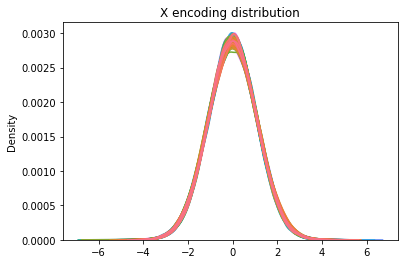

In [63]:
def make_encoding_distribution_plots(outs_enc, elem, show=False, legend=False):
    outs_enc_df = pd.DataFrame(outs_enc, columns=list(range(outs_enc.shape[1])))

    g = sns.kdeplot(data=outs_enc_df, legend=legend)

    plt.title(f"{elem} encoding distribution")

    if show:
        plt.show()


make_encoding_distribution_plots(x_outs_enc, "X", True, False)

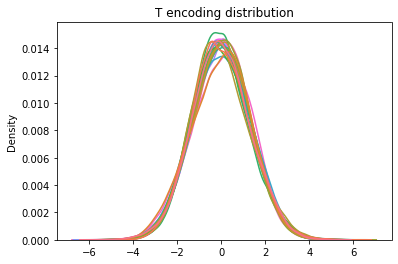

In [64]:
make_encoding_distribution_plots(t_outs_enc, "T", True, False)

In [68]:
def all_generate(x_vae_learn, x_to, t_vae_learn, t_to, df, x_mu=None, x_std=None,
                 t_mu=None, t_std=None, N=100000, suffix="_synth", evaluate=False):
    def correct_mu_std(vae_learn, mu, std):
        if mu is None or std is None:
            outs_enc = encode(vae_learn, df)[0]

            mu = outs_enc.mean() if mu is None else mu
            std = outs_enc.std() if std is None else std

        return mu, std

    x_mu, x_std = correct_mu_std(x_vae_learn, x_mu, x_std)
    t_mu, t_std = correct_mu_std(t_vae_learn, t_mu, t_std)

    t_synth, t_synth_enc = generate(t_vae_learn, t_to, N, t_config, t_mu, t_std)
    x_synth, x_synth_enc = generate(x_vae_learn, x_to, N, x_config, x_mu, x_std)
    #
    synth_df = pd.concat([x_synth, t_synth], axis=1)
    synth_df.columns = list(map(lambda x: f"{x}{suffix}", synth_df.columns))

    eval = None
    if evaluate:
        eval = evaluate_ood_gen(synth_df, df, x_vae_learn, t_vae_learn, cat_names)

    return synth_df, (x_synth, t_synth), (t_synth_enc.cpu().numpy(), x_synth_enc.cpu().numpy()), eval


def analyse_entropy(synth_df, real_df, categ_cols):
    """Checks the entropy of each value of each column"""

    def cols_entropy(df):
        res_entr = {}
        res_val_count = {}
        for col in df.columns:
            res_val_count[col] = df[col].value_counts() / df[col].shape[0]
            res_entr[col] = entropy(res_val_count[col])
        res_entr = pd.DataFrame(res_entr, index=[0])
        return res_entr, res_val_count

    real_df_entr, real_df_val_c = cols_entropy(real_df[categ_cols])
    synth_df_entr, synth_df_val_c = cols_entropy(synth_df[categ_cols])

    comp_val_c = {}
    for c, v in real_df_val_c.items():
        comp_val_c[c] = pd.DataFrame({f"{c}_real": real_df_val_c[c], f"{c}_synth": synth_df_val_c[c]}).fillna(0.0)

    comp_entr = (synth_df_entr - real_df_entr).mean()

    # df_entr = pd.concat([real_df_entr, synth_df_entr])

    return comp_entr, real_df_entr, synth_df_entr, comp_val_c


def get_pvalue_uncertainty(org_enc, new_enc, learn=None, use_encoder=False):
    if use_encoder:
        org_enc = encode(learn, org_enc)[0]
        new_enc = encode(learn, new_enc)[0]

    org_gn = torch.exp(Normal(torch.from_numpy(org_enc.mean(axis=0)), torch.from_numpy(org_enc.std(axis=0)))
                       .log_prob(torch.from_numpy(new_enc))).mean(axis=1)

    return org_gn


def evaluate_ood_gen(synth_df, real_df, t_learn, x_learn, categ_cols):
    new_uniq = new_unique_rows_generated(synth_df, real_df, categ_cols)
    comp_entr, real_df_entr, synth_df_entr, value_count_comp = analyse_entropy(synth_df, real_df, categ_cols)

    t_alea_unc = get_pvalue_uncertainty(real_df, synth_df, learn=t_learn, use_encoder=True)
    x_alea_unc = get_pvalue_uncertainty(real_df, synth_df, learn=x_learn, use_encoder=True)

    total_alea_unc = (x_alea_unc.numpy(), t_alea_unc.numpy())

    return new_uniq, comp_entr, total_alea_unc, value_count_comp, real_df_entr, synth_df_entr


In [69]:
real_df = transform_df(x_vae_learn, x_to, t_vae_learn, t_to, df)

synth_df, (x_synth_df, t_synth_df), synth_enc, synth_df_ood_perf = all_generate(x_vae_learn, x_to, t_vae_learn, t_to,
                                                                                df,
                                                                                suffix="",
                                                                                x_mu=x_outs_enc.mean(),
                                                                                x_std=x_outs_enc.std(),
                                                                                t_mu=t_outs_enc.mean(),
                                                                                t_std=t_outs_enc.std(),
                                                                                evaluate=True)

In [70]:
real_df

,workclass,education,marital-status,occupation,relationship,sex,native-country,education-num_na,education-num,capital-loss,capital-gain,hours-per-week,race,age
0,5,8,3,0,6,1,40,1,12.000,1902.000,0.000,40.000,5,49.000
1,5,13,1,5,2,2,40,1,14.000,-0.000,10520.000,45.000,5,44.000
2,5,12,1,0,5,1,40,2,10.000,-0.000,0.000,32.000,3,38.000
3,6,15,3,11,1,2,40,1,15.000,-0.000,0.000,40.000,2,38.000
4,7,6,3,9,6,1,40,2,10.000,-0.000,0.000,50.000,3,42.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,5,10,1,11,2,2,40,1,13.000,-0.000,14084.000,40.000,5,36.000
32557,1,10,5,1,4,2,40,1,13.000,-0.000,0.000,40.000,4,23.000
32558,5,8,3,8,1,2,40,1,12.000,-0.000,0.000,40.000,5,53.000
32559,3,12,3,15,6,1,40,1,9.000,-0.000,4064.000,22.000,5,32.000


In [72]:
synth_df

,workclass,education,marital-status,occupation,relationship,sex,native-country,education-num_na,education-num,capital-loss,capital-gain,hours-per-week,race,age
0,5.000,12.000,3.000,4.000,1.000,2.000,40.000,1.000,9.632,11.847,86.569,38.163,5.000,40.195
1,5.000,16.000,5.000,2.000,1.000,2.000,40.000,1.000,10.759,22.795,137.223,40.522,5.000,32.504
2,5.000,12.000,3.000,2.000,2.000,2.000,40.000,1.000,9.734,11.372,75.372,38.139,5.000,31.809
3,1.000,16.000,5.000,1.000,4.000,1.000,40.000,1.000,9.668,3.097,26.850,34.159,5.000,39.810
4,5.000,10.000,3.000,5.000,1.000,2.000,40.000,1.000,11.297,35.826,177.861,40.513,5.000,32.187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5.000,12.000,1.000,5.000,2.000,2.000,40.000,1.000,10.586,14.349,442.174,41.576,5.000,42.099
99996,5.000,16.000,3.000,11.000,1.000,2.000,40.000,1.000,10.941,15.627,164.406,35.976,5.000,39.618
99997,5.000,16.000,5.000,9.000,4.000,2.000,40.000,1.000,8.580,5.528,71.343,32.617,5.000,29.980
99998,5.000,12.000,3.000,2.000,1.000,2.000,40.000,1.000,10.188,8.943,178.816,40.786,5.000,30.380


In [88]:
synth_df_ood_perf[3]

{'workclass':                    workclass_real  workclass_synth
 1.0                         0.000            0.003
 5.0                         0.000            0.997
 7.0                         0.000            0.000
  ?                          0.056            0.000
  Federal-gov                0.029            0.000
  Local-gov                  0.064            0.000
  Never-worked               0.000            0.000
  Private                    0.697            0.000
  Self-emp-inc               0.034            0.000
  Self-emp-not-inc           0.078            0.000
  State-gov                  0.040            0.000
  Without-pay                0.000            0.000,
 'education':                education_real  education_synth
 1.0                     0.000            0.001
 2.0                     0.000            0.001
 6.0                     0.000            0.000
 9.0                     0.000            0.000
 10.0                    0.000            0.127
 11.0    

workclass        -1.121
education        -1.058
marital-status   -0.450
occupation       -0.797
relationship     -0.567
race             -0.373
sex              -0.221
native-country   -0.654
dtype: float64

In [75]:
ood_data = {"x_ood": transform(x_vae_learn, x_df, x_to)[0],
            "t_ood": transform(t_vae_learn, t_df, t_to)[0],
            "x_uncert": np.full((x_df.shape[0], 1), 0),
            "t_uncert": np.full((t_df.shape[0], 1), 0),
            "devi": np.full((x_df.shape[0], 1), 0)}
for deviat in tqdm([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]):
    abnor_synth_df, (abnor_x_synth_df, abnor_t_synth_df), abnor_synth_enc, abnor_synth_df_ood_perf = \
        all_generate(x_vae_learn, x_to, t_vae_learn, t_to, df,
                     N=10000,
                     suffix="",
                     x_mu=x_outs_enc.mean(),
                     x_std=x_outs_enc.std() * deviat,
                     t_mu=t_outs_enc.mean(),
                     t_std=t_outs_enc.std() * deviat,
                     evaluate=True)
    ood_data['x_ood'] = np.append(ood_data['x_ood'], abnor_x_synth_df, axis=0)
    ood_data['t_ood'] = np.append(ood_data['t_ood'], abnor_t_synth_df, axis=0)
    ood_data['x_uncert'] = np.append(ood_data['x_uncert'], abnor_synth_df_ood_perf[2][0][:, np.newaxis], axis=0)
    ood_data['t_uncert'] = np.append(ood_data['t_uncert'], abnor_synth_df_ood_perf[2][1][:, np.newaxis], axis=0)
    ood_data['devi'] = np.append(ood_data['devi'], np.full((abnor_synth_enc[1].shape[0], 1), deviat), axis=0)

100%|██████████| 11/11 [01:05<00:00,  5.93s/it]


workclass


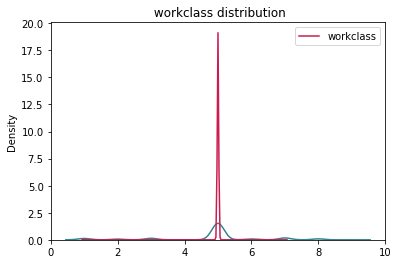

education


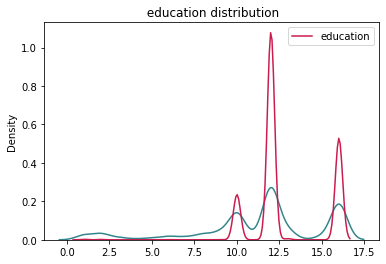

marital-status


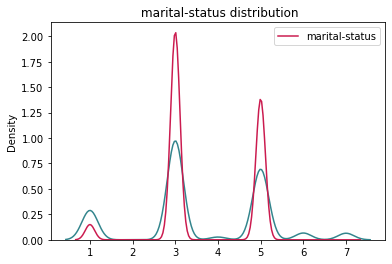

occupation


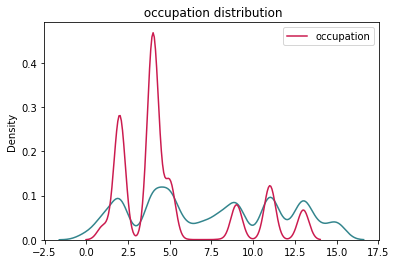

relationship


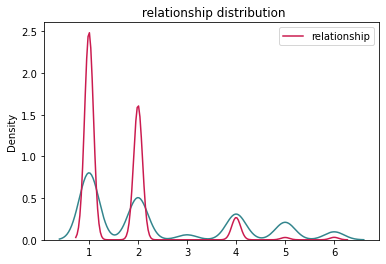

race


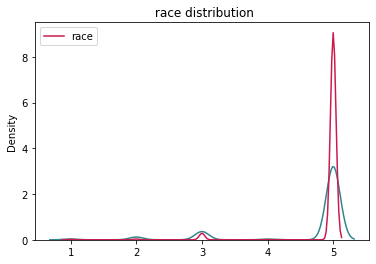

sex


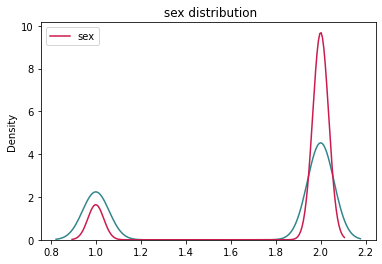

native-country


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



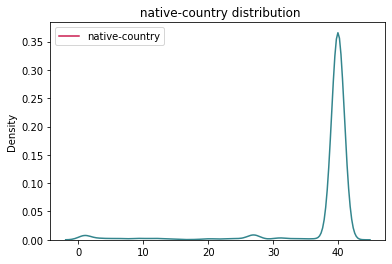

age


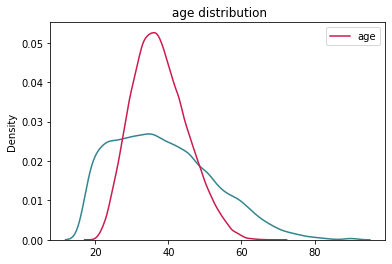

education-num


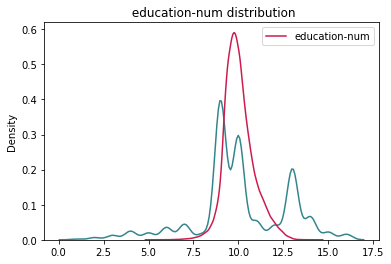

capital-loss


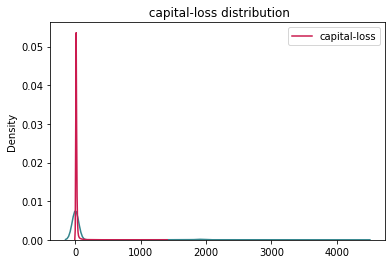

capital-gain


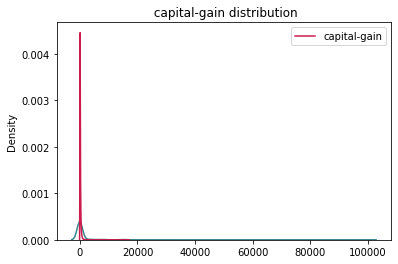

hours-per-week


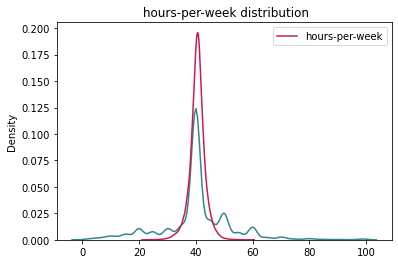

In [78]:
# Distribution of synthetic columns vs real columns
import seaborn as sns
import matplotlib.pyplot as plt
for scol in all_cols:
    print(scol)
    sns.kdeplot(data=real_df[[scol]], palette="crest")
    sns.kdeplot(data=synth_df[[scol]], palette='rocket')
    plt.title(f" {scol} distribution")
    plt.show()